In [380]:
import numpy as np
import scipy.integrate as integrate
from numpy.linalg import inv
import math as m
from functions import *
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
import importlib
from fpdf import FPDF

%load_ext autoreload

%autoreload 2

np.set_printoptions(suppress=True)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


This next block will create a class for all of our inputs to be placed into. This will allow for all inputs to have easily accessed names, values, and units.

In [381]:
class Input:
    def __init__(self, name, value, unit):
        self.name = name
        self.value = value
        #self.valueType = type(value)
        self.unit = unit
    
    def print_values(self):
        print("\n")
        for attr, value in self.__dict__.items():
            print(f"{attr}: {value}")

# Please fill in all inputs and their units below
# v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v v 

# Constants
<br>For Reference: Units Set: psi, in, in4, lb/in, lb

In [382]:
YOUNGSMODULUS = 30 * (10**6)
YM_UNIT = "psi"

MOI = 0.8
MOI_UNIT = "in4"

#options are "Circular" or "Square"
cross_section = "Circular"

W2 = 100/12
W3 = 100/12 
dist_load_length = 6*12 #length that the distributed load acts upon in the corresponding units to W3
load_direction = -1 #negative 1 if distributed load points down, +1 otherwise
loaded_elements = [1]
FORCE_UNIT = "lb"

HINGE_NODES = [3]

nArray = np.array([[1,2], [2,3], [3,4], [4,5]])
print(f"number of elements: {len(nArray)}")

coords = np.array([[0,0], [6,0], [10,0], [12,0], [14,0]])

LENGTHS_UNIT = "in"
LENGTHS_CONVERSION_FACTOR = 12 #input conversion factor if inputted coordinate values are not in final units
#1 if no conversion needed

problem_number = 3

homework_number = 7




number of elements: 4


# Boundary Conditions
#### for v & phi: [node#, v, phi] -> v and phi are assumed to be unknown (None) -> only input if known
#### for forces: [node#, Fy, moment] -> forces and moments are assumed to be 0 -> only input if not 0

<br>Please note, node# are inputted straight from the diagram - do not adjust for python counting

In [383]:
v_phi_bcs = np.array([[1, 0, None], [2, 0, None], [5, 0, None]])

forceMoment_BCs = np.array([[1, None, 0], [2, None, 0], [4, -150, 0], [5, None, 0]])

# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Create our final output pdf

In [384]:
filename = f'HW{homework_number} Problem {problem_number} Numerical Outputs.txt'
f = open(filename, 'w')

f = open(filename, 'a')
f.write(f"Numerical Outputs for HW{str(homework_number)} Problem {str(problem_number)}\n\n")

37

In [385]:
E = Input("Young's Modulus", YOUNGSMODULUS, YM_UNIT)
E.print_values()

I_ = Input("Moment of Inertia", MOI, MOI_UNIT)
I_.print_values()

nodes = Input("Node numbers", nArray, "None")
nodes.print_values()

coords *= LENGTHS_CONVERSION_FACTOR

node_coords = Input("Node Coordinates (x, y)", coords, "None")
node_coords.print_values()

total_length = np.max(node_coords.value)
print(f"\ntotal length: {total_length} {LENGTHS_UNIT}")

HINGE_NODES = [x - 1 for x in HINGE_NODES]
print(f"Hinge Nodes at: {HINGE_NODES} (adjusted)")



name: Young's Modulus
value: 30000000
unit: psi


name: Moment of Inertia
value: 0.8
unit: in4


name: Node numbers
value: [[1 2]
 [2 3]
 [3 4]
 [4 5]]
unit: None


name: Node Coordinates (x, y)
value: [[  0   0]
 [ 72   0]
 [120   0]
 [144   0]
 [168   0]]
unit: None

total length: 168 in
Hinge Nodes at: [2] (adjusted)


number of elements is the number of rows in nodes
<br>number of nodes is the maximum number found in nodes

In [386]:
count_elems = len(nodes.value)
print(f"number of elements: {count_elems}")

count_nodes = nodes.value.max()
print(f"number of nodes: {count_nodes}")

dimension = (2*count_nodes) + len(HINGE_NODES)
print(f"dimension = {dimension}")

number of elements: 4
number of nodes: 5
dimension = 11


In [387]:
LENGTHS = np.zeros(count_elems)
print(LENGTHS)

for i in range(count_elems):

    connection = nodes.value[i]
    N1 = connection[0]
    N2 = connection[1]

    x1 = (node_coords.value[N1-1])[0]
    y1 = (node_coords.value[N1-1])[1]

    x2 = (node_coords.value[N2-1])[0]
    y2 = (node_coords.value[N2-1])[1]

    LENGTHS[i] = get_element_length(x1, y1, x2, y2)

    print(f"element {i+1}: length = {LENGTHS[i]}")

print(LENGTHS)

lengths = Input("Lengths", LENGTHS, LENGTHS_UNIT)
lengths.print_values()


[0. 0. 0. 0.]
element 1: length = 72.0
element 2: length = 48.0
element 3: length = 24.0
element 4: length = 24.0
[72. 48. 24. 24.]


name: Lengths
value: [72. 48. 24. 24.]
unit: in


two reactions per node
<br>v_phi_list -> list of unknowns (node displacements)
<br>we can input our known values -> fixed_nodes at nodes 4 & 5
<br>these fixed nodes numbers are taken straight from diagram (not adjusted for python counting)
<br><br>u and v for any given node is given as (node# - 1)* 2 and ((node# -1)* 2) + 1 respectively.


In [388]:
v_phi_list = [None]*(dimension - len(HINGE_NODES))
print("displacement bcs: [node number, y disp (v), angle of rotation (phi)]")
print(v_phi_bcs)

adjust_array(v_phi_list, v_phi_bcs, "displacements")
for node in HINGE_NODES:
    v_phi_list.insert((node*2)+2, None)
print("v & phi list:")
print(v_phi_list)

displacement bcs: [node number, y disp (v), angle of rotation (phi)]
[[1 0 None]
 [2 0 None]
 [5 0 None]]
adjusting array to account for: displacements boundary conditions
case 1 for BC 1
case 4 for BC 1
case 1 for BC 2
case 4 for BC 2
case 1 for BC 3
case 4 for BC 3
done adjusting displacements array!
v & phi list:
[0, None, 0, None, None, None, None, None, None, 0, None]


Same procedure as displacement BCs for forces
<br>Input BCs given as : [node #, x force, y force]

In [389]:
force_list = [0]*(dimension - len(HINGE_NODES))
#force_list = np.zeros(((count_nodes*2), 1))

nodesWithLoads = []

loadedNodes = 0

for i in range(len(forceMoment_BCs)):
    if forceMoment_BCs[i,1] != None or forceMoment_BCs[i,2] != None:
        loadedNodes += 1
        nodesWithLoads.append((forceMoment_BCs[i,0] - 1))

for i in range(len(force_list)):
    if v_phi_list[i] == 0:
        force_list[i] = None
    elif v_phi_list[i] is None:
        force_list[i] = 0

#adjust force array given concentrated loading conditions
adjust_array(force_list, forceMoment_BCs, "forces")

#add in extra reactions for hinges
for node in HINGE_NODES:
    force_list.insert((node*2)+2, 0)

print(f"number of nodes with concentrated loads: {loadedNodes}")
print(f"at nodes: {nodesWithLoads}")

print(f"force list: \n{force_list}")

for i in range(len(force_list)):
    if force_list[i] == v_phi_list[i]:
        print(f"Error in checking BCs: index {i} in forcelist is equal to displist")

adjusting array to account for: forces boundary conditions
case 3 for BC 1
case 4 for BC 1
case 3 for BC 2
case 4 for BC 2
case 1 for BC 3
case 4 for BC 3
case 1 for BC 4
Case 2 for BC 4
done adjusting forces array!
number of nodes with concentrated loads: 4
at nodes: [0, 1, 3, 4]
force list: 
[None, 0, None, 0, 0, 0, 0, -150, 0, None, 0]


### Accounting for surface traction

In [390]:
if W3 != 0:
    m_constant = (W3 - W2)/dist_load_length

    def line(x, b):
        return (m_constant * x) + b if W3 != W2 \
            else W3    
    
    loose_ft = [0] * (count_elems * 4)

    fw = [0] * (dimension - len(HINGE_NODES))
    #for each element, create local fw and transport to global
    for i in range(count_elems):
        if (i+1) in loaded_elements:
            b_constant = sum_until_n(lengths.value, (i-1)) * m_constant
            print(f"for element {i+1}: b constant: {b_constant}")

            tStar1 = lambda x: (create_NT(x, lengths.value[i]))[0,0] * load_direction * line(x, b_constant)
            tStar2 = lambda x: (create_NT(x, lengths.value[i]))[0,1] * load_direction * line(x, b_constant)
            tStar3 = lambda x: (create_NT(x, lengths.value[i]))[0,2] * load_direction * line(x, b_constant)
            tStar4 = lambda x: (create_NT(x, lengths.value[i]))[0,3] * load_direction * line(x, b_constant) 

            ft1, error = integrate.quad(tStar1, 0, lengths.value[i])
            ft2, error = integrate.quad(tStar2, 0, lengths.value[i])
            ft3, error = integrate.quad(tStar3, 0, lengths.value[i])
            ft4, error = integrate.quad(tStar4, 0, lengths.value[i]) 

            fw[2*i] += ft1
            fw[(2*i) + 1] += ft2
            fw[(2*i) + 2] += ft3
            fw[(2*i) + 3] += ft4

            loose_ft[(4*i)] = ft1
            loose_ft[(4*i) + 1] = ft2
            loose_ft[(4*i) + 2] = ft3
            loose_ft[(4*i) + 3] = ft4

            print(f"ft1 = {ft1}, ft2 = {ft2}, ft3 = {ft3}, ft4 = {ft4}")
    print(f"loose ft = {loose_ft}, length = {len(loose_ft)}")
else:
    fw = 0

for node in HINGE_NODES:
    fw.insert((node*2)+1, 0)
    print(f"inserted 0 into fw at index: {(node*2) + 1}")
    print(f"new length of fw: {len(fw)}")

print(f"fw = {fw}")


for element 1: b constant: 0.0
ft1 = -300.0, ft2 = -3600.0000000000014, ft3 = -299.99999999999994, ft4 = 3599.9999999999995
loose ft = [-300.0, -3600.0000000000014, -299.99999999999994, 3599.9999999999995, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], length = 16
inserted 0 into fw at index: 5
new length of fw: 11
fw = [-300.0, -3600.0000000000014, -299.99999999999994, 3599.9999999999995, 0, 0, 0, 0, 0, 0, 0]


Global [k] matrix is a symmetric array of shape (dimension, dimension)
<br>beam constants are one per element, stored in an array of shape (number of elements, 1).

In [391]:
global_K = np.zeros((dimension, dimension))
print(f"Global K array dimensions: {global_K.shape}")

beam_constant = np.zeros((count_elems,1))
for i in range(count_elems):
    print(f"E = {E.value}, I = {I_.value}, length for element {i+1} = {lengths.value[i]}")
    beam_constant[i] = (E.value*I_.value)/(lengths.value[i]**3)

print(f"beam constants = \n{beam_constant}")

Global K array dimensions: (11, 11)
E = 30000000, I = 0.8, length for element 1 = 72.0
E = 30000000, I = 0.8, length for element 2 = 48.0
E = 30000000, I = 0.8, length for element 3 = 24.0
E = 30000000, I = 0.8, length for element 4 = 24.0
beam constants = 
[[  64.30041152]
 [ 217.01388889]
 [1736.11111111]
 [1736.11111111]]


## Creating the finite element equation for each Truss Element
### Combining into the global K array

In [392]:
wall = np.zeros((10,10))
block = np.arange(1,7).reshape(2,3)

x = 3
y = 3
wall[x:x+block.shape[0], y:y+block.shape[1]] = block
print(wall)

[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 2. 3. 0. 0. 0. 0.]
 [0. 0. 0. 4. 5. 6. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]


In [393]:
hinge_counter = 0
for i in range(count_elems):
    local_K = create_beam_local_k(lengths.value[i])
    local_K *= beam_constant[i]
    print(f"\nk matrix for element {i+1}: \n{local_K}")
    #print(local_K)
    start_node = nodes.value[i,0]
    end_node = nodes.value[i,1]
    print(f"Element {i+1} starting at node: {start_node} and ending at node: {end_node}")
    #print(np.vsplit(local_K, 2))
    Sn = (start_node - 1)*2
    En = (end_node - 1)*2

    x = Sn + hinge_counter
    y = x

    if HINGE_NODES is not None and (start_node - 1) in HINGE_NODES:
        row_to_insert = np.zeros((1,4))
        col_to_insert = np.zeros((5))

        local_K = np.insert(local_K, 1, row_to_insert, axis = 0)
        local_K = np.insert(local_K, 1, col_to_insert, axis = 1)

        print(f"\nHinge modified K Matrix for element {i+1}: \n{local_K}")

        hinge_counter += 1
    print(f"\nk matrix for element {i+1} inputted at global matrix position {x},{y}")

    global_K[x:x+local_K.shape[0], y:y+local_K.shape[1]] += local_K

print(f"\nGlobal K matrix: \n{global_K}")
unmodified_global_K = global_K.copy()
check_symmetric(global_K)
print(f"Zero rows at: {np.where(~global_K.any(axis=1))[0]}")


k matrix for element 1: 
[[    771.60493827   27777.77777778    -771.60493827   27777.77777778]
 [  27777.77777778 1333333.33333333  -27777.77777778  666666.66666667]
 [   -771.60493827  -27777.77777778     771.60493827  -27777.77777778]
 [  27777.77777778  666666.66666667  -27777.77777778 1333333.33333333]]
Element 1 starting at node: 1 and ending at node: 2

k matrix for element 1 inputted at global matrix position 0,0

k matrix for element 2: 
[[   2604.16666667   62500.           -2604.16666667   62500.        ]
 [  62500.         2000000.          -62500.         1000000.        ]
 [  -2604.16666667  -62500.            2604.16666667  -62500.        ]
 [  62500.         1000000.          -62500.         2000000.        ]]
Element 2 starting at node: 2 and ending at node: 3

k matrix for element 2 inputted at global matrix position 2,2

k matrix for element 3: 
[[  20833.33333333  250000.          -20833.33333333  250000.        ]
 [ 250000.         4000000.         -250000.       

In [394]:
if W3 != 0:  
    for i in range(len(force_list)):
        if force_list[i] is not None:
            force_list[i] += fw[i]
        else: force_list[i] = fw[i]
print(force_list)

[-300.0, -3600.0000000000014, -299.99999999999994, 3599.9999999999995, 0, 0, 0, -150, 0, 0, 0]


    #if j in nodesWithLoads:
     #   j+=2

In [395]:
j = 0
print(np.shape(global_K))
while j < dimension:
    print(f"{j}")

    #first case: displacement BC = 0. In this case, set combined force values to 0, and alter 
    #global_K to reflect the changes.
    if v_phi_list[j] == 0:
        print(f"u = 0 at row: {j}")
        force_list[j] = 0 
        global_K[j] = 0
        global_K[j,j] = 1
        j+=1
    elif v_phi_list[j] is None:
        print(f"unknown u/phi at row {j}")
        j+=1
    else: #when we have a known, non-zero displacement boundary condition
        #alter global stiffness to all zeros and one 1, and set force equal to displacement BC
        print(f"row {j} altered")
        print(v_phi_list[j])
        force_list[j] = v_phi_list[j]
        for c in range(count_nodes):
            global_K[j,c] = 1 if global_K[j,c] > 0 else 0
        j+=1


print(f"global K -> \n{global_K}")
print(f"force list -> \n{force_list}")

(11, 11)
0
u = 0 at row: 0
1
unknown u/phi at row 1
2
u = 0 at row: 2
3
unknown u/phi at row 3
4
unknown u/phi at row 4
5
unknown u/phi at row 5
6
unknown u/phi at row 6
7
unknown u/phi at row 7
8
unknown u/phi at row 8
9
u = 0 at row: 9
10
unknown u/phi at row 10
global K -> 
[[      1.               0.               0.               0.
        0.               0.               0.               0.
        0.               0.               0.        ]
 [  27777.77777778 1333333.33333333  -27777.77777778  666666.66666667
        0.               0.               0.               0.
        0.               0.               0.        ]
 [      0.               0.               1.               0.
        0.               0.               0.               0.
        0.               0.               0.        ]
 [  27777.77777778  666666.66666667   34722.22222222 3333333.33333333
   -62500.         1000000.               0.               0.
        0.               0.               0.    

In [396]:
#global_K.round(0)
global_K_inv = inv(global_K)
#print(global_K_inv)

node = 1

final_u_phi = np.matmul(global_K_inv, force_list)

print(f"Final u and phi: {final_u_phi}")

rounded_u_phi = [round(u_phi , 6) for u_phi in final_u_phi]
f.write(f"\nDisplacements, Angles of Rotation = \n{rounded_u_phi}" 
        f"\n{LENGTHS_UNIT}, rad")

Final u and phi: [ 0.     -0.0036  0.      0.0018 -0.0288 -0.0018 -0.0003 -0.0288  0.0006
  0.      0.0015]


130

### Finding forces

In [397]:
elem_forces_moments = [0] * (count_elems*4)
force_hinge_counter = 0
print(len(loose_ft))
for i in range(count_elems):
    start_node = nodes.value[i,0]
    if W3 != 0:
        local_K = create_beam_local_k(lengths.value[i])
        local_K *= beam_constant[i]

        mover = 4*i

        indexer = 2*i + force_hinge_counter

        print(f"local K element {i+1} = {local_K}")
        if HINGE_NODES is not None and (start_node - 1) in HINGE_NODES:
            #if we have hinges and the element begins on a hinge
            print(f"Code FF01: at element {i+1}")
            local_U = np.array([
            [final_u_phi[indexer]],
            [final_u_phi[indexer + 2]], 
            [final_u_phi[indexer + 3]], 
            [final_u_phi[indexer + 4]]
            ])

            local_fw = np.array([
            [loose_ft[mover]], 
            [loose_ft[mover + 2]], 
            [loose_ft[mover + 3]], 
            [loose_ft[mover + 4]]
            ])

            force_hinge_counter += 1
            print(f"\nlocal fw for element {i+1} = {local_fw}")

        else:
            print(f"Code FF02: at element {i+1}")
            local_U = np.array([
            [final_u_phi[2*i + force_hinge_counter]],
            [final_u_phi[(2*i) + 1 + force_hinge_counter]], 
            [final_u_phi[(2*i) + 2 + force_hinge_counter]], 
            [final_u_phi[(2*i) + 3 + force_hinge_counter]]
            ])

            local_fw = np.array([
            [loose_ft[mover]], 
            [loose_ft[mover + 1]], 
            [loose_ft[mover + 2]], 
            [loose_ft[mover + 3]]
            ])

            print(f"\nLocal U phi for element {i+1} : \n{local_U}")
        local_forces = np.subtract((local_K @ local_U), local_fw)

    else:
        local_K = create_beam_local_k(lengths.value[i])
        local_K *= beam_constant[i]

        indexer = 2*i + force_hinge_counter
        
        if HINGE_NODES is not None and (start_node - 1) in HINGE_NODES:
            print(f"Code FF03: at element {i+1}")
            local_U = np.array([
            [final_u_phi[indexer]],
            [final_u_phi[indexer + 2]], 
            [final_u_phi[indexer + 3]], 
            [final_u_phi[indexer + 4]]
            ])

            force_hinge_counter += 1
        
        else:
            print(f"Code FF04: at element {i+1}")
            local_U = np.array([
            [final_u_phi[indexer]],
            [final_u_phi[indexer + 1]], 
            [final_u_phi[indexer + 2]], 
            [final_u_phi[indexer + 3]]
            ])
        local_forces = local_K @ local_U

    #negatives convert to EB sign convention
    #local_forces[1,0] *= -1
    #local_forces[2,0] *= -1

    elem_forces_moments[4*i] = local_forces[0,0]
    elem_forces_moments[4*i + 1] = local_forces[1,0]
    elem_forces_moments[4*i + 2] = local_forces[2,0]
    elem_forces_moments[4*i + 3] = local_forces[3,0]

    print(f"local forces (element {i+1}) [{FORCE_UNIT}] = \n{local_forces}")

print(f"collected element forces [{FORCE_UNIT}] = \n{elem_forces_moments}")
rounded_f_m = [round(element , 4) for element in elem_forces_moments]
f.write(f"\n\nForces, Moments = \n{rounded_f_m}\n{FORCE_UNIT}, {FORCE_UNIT}*{LENGTHS_UNIT}")


16
local K element 1 = [[    771.60493827   27777.77777778    -771.60493827   27777.77777778]
 [  27777.77777778 1333333.33333333  -27777.77777778  666666.66666667]
 [   -771.60493827  -27777.77777778     771.60493827  -27777.77777778]
 [  27777.77777778  666666.66666667  -27777.77777778 1333333.33333333]]
Code FF02: at element 1

Local U phi for element 1 : 
[[ 0.    ]
 [-0.0036]
 [ 0.    ]
 [ 0.0018]]
local forces (element 1) [lb] = 
[[  250.]
 [   -0.]
 [  350.]
 [-3600.]]
local K element 2 = [[   2604.16666667   62500.           -2604.16666667   62500.        ]
 [  62500.         2000000.          -62500.         1000000.        ]
 [  -2604.16666667  -62500.            2604.16666667  -62500.        ]
 [  62500.         1000000.          -62500.         2000000.        ]]
Code FF02: at element 2

Local U phi for element 2 : 
[[ 0.    ]
 [ 0.0018]
 [-0.0288]
 [-0.0018]]
local forces (element 2) [lb] = 
[[  75.]
 [3600.]
 [ -75.]
 [  -0.]]
local K element 3 = [[  20833.33333333  25000

142

## Finding Stresses

In [398]:
elem_forces = [0] * (count_elems * 2)
elem_moments = [0] * (count_elems * 2)

for i in range(len(elem_forces_moments)):
    if check_even(i) == True:
        elem_forces[int(i / 2)] = elem_forces_moments[i]
    else:
        elem_moments[int((i-1) / 2)] = elem_forces_moments[i]

print(f"elem forces (fea sign convention) = \n{elem_forces}")
print(f"elem moments (fea sign convention) = \n{elem_moments}")

abs_forces = [abs(element) for element in elem_forces]
abs_moments = [abs(element) for element in elem_moments]

max_force = max(abs_forces)
max_moment = max(abs_moments)

print(f"max force = {max_force}, max moment = {max_moment}")

if cross_section == "Circular":
    print("SM Code 1: circular cross section")
    radius = ((4*I_.value)/m.pi)**0.25
    max_trans_shear = (4*max_force)/(3*((m.pi)*(radius**2)))
    max_bending_stress = (max_moment * radius)/(I_.value)

elif cross_section == "Square":
    print("SM Code 2: square cross section")
    side_length = (12 * I_.value)**0.25
    max_trans_shear = (3*max_force)/(2*(side_length**2))
    max_bending_stress = (max_moment * side_length * 0.5)/(I_.value)

else:
    print(f"Error SM1: Calculating for a {cross_section} cross section is not supported.")

print(f"\nmaximum transverse shear stress = {max_trans_shear} {YM_UNIT}")
f.write(f"\n\nMaximum transverse shear stress = {str(round(max_trans_shear, 4))} {YM_UNIT}")

print(f"\nmaximum bending stress = {max_bending_stress} {YM_UNIT}")
f.write(f"\n\nMaximum bending stress = {str(round(max_bending_stress, 4))} {YM_UNIT}")

elem forces (fea sign convention) = 
[249.99999999999983, 350.0000000000001, 75.00000000000001, -75.00000000000001, 74.99999999999966, -74.99999999999966, -75.00000000000074, 75.00000000000074]
elem moments (fea sign convention) = 
[-9.094947017729282e-13, -3600.0000000000086, 3600.0000000000045, -3.183231456205249e-12, -1.0913936421275139e-11, 1800.0000000000027, -1800.0000000000095, -9.094947017729282e-12]
max force = 350.0000000000001, max moment = 3600.0000000000086
SM Code 1: circular cross section

maximum transverse shear stress = 147.18273045117607 psi

maximum bending stress = 4520.77133112961 psi


40

y values = [250.0, -350.0, 75.0, 75.0, 75.0, 75.0, -75.0, -75.0, 0]
0
1
2
3
x values = [0, 72, 72, 120, 120, 144, 144, 168, 168]
y values = [0.0, -3600.0, -3600.0, -0.0, 0.0, 1800.0, 1800.0, -0.0, 0]
x values = [0, 72, 72, 120, 120, 144, 144, 168, 168]
local x adjustment factor = 0
element 1: start node 1
0.0 72.0
Element 1: DF Code 2
[3.0596691616063816e-15, -0.0036000000000000194, 1.4367174117069225e-15, 0.0017999999999999692]
local x adjustment factor = 72
element 2: start node 2
72.0 120.0
Element 2: DF Code 2
[1.4367174117069225e-15, 0.0017999999999999692, -0.028800000000000242, -0.0018000000000000388]
local x adjustment factor = 120
element 3: start node 3
120.0 144.0
Element 3: DF Code 1
[-0.028800000000000242, -0.000300000000000001, -0.028800000000000173, 0.0006000000000000055]
local x adjustment factor = 144
element 4: start node 4
144.0 168.0
Element 4: DF Code 2
[-0.028800000000000173, 0.0006000000000000055, 0.0, 0.0015000000000000057]


<Figure size 640x480 with 0 Axes>

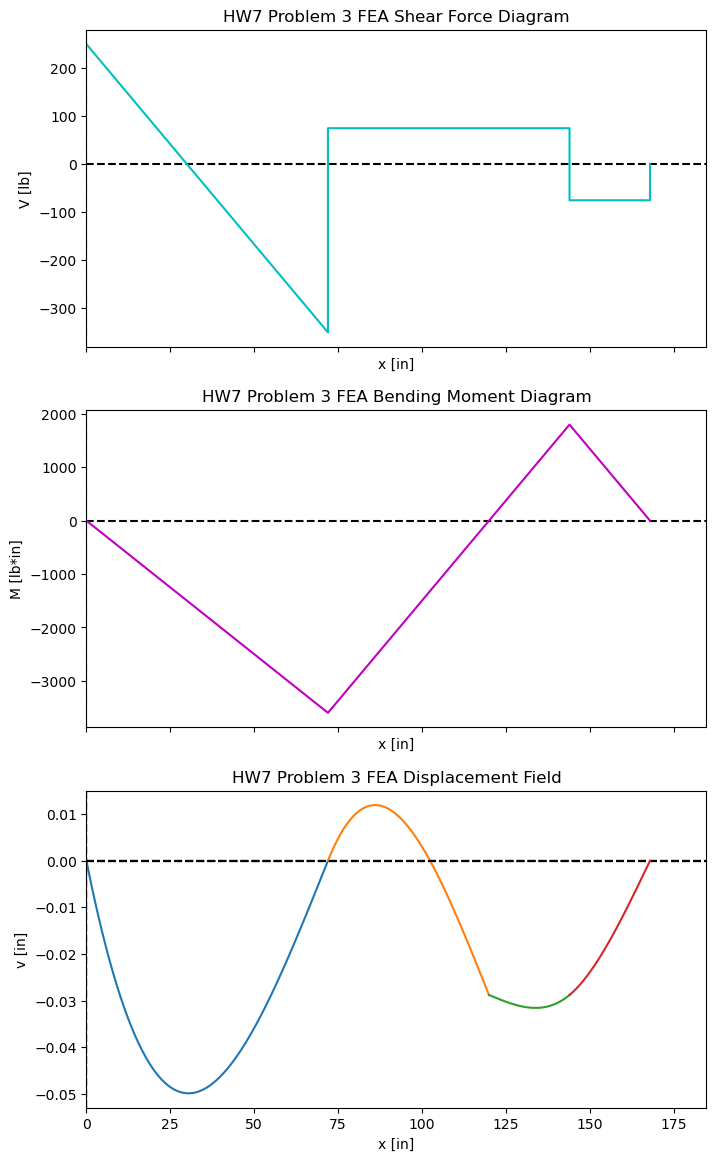

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [399]:
#Shear Force Diagram
for i in range(len(elem_forces)):
    if check_even(i) == False:
        elem_forces[i] *= -1

shear_y_values = elem_forces
shear_y_values = [round(elem, 4) for elem in shear_y_values]
shear_y_values.append(0)
print(f"y values = {shear_y_values}")

x_values = [0] * len(elem_forces)

for i in range(count_elems):
    print(i)
    x_values[2*i] += node_coords.value[i][0]
    x_values[(2*i) + 1] += node_coords.value[i+1][0]

x_values.append(x_values[len(elem_forces) - 1])

print(f"x values = {x_values}")

shear_fig = plt.figure("Shear Figure")

figure, ax = plt.subplots(nrows=3,ncols=1,sharex=True,figsize=(8,14))
#plt.rcParams["figure.figsize"] = [10, 14]
#plt.rcParams["figure.autolayout"] = True

ax[0].set_title(f"HW{homework_number} Problem {problem_number} FEA Shear Force Diagram")
ax[0].set_xlim(0, total_length * 1.1)
ax[0].axhline(0, color="black", linestyle = "--")
ax[0].axvline(0, color="black", linestyle = "--")
ax[0].set_ylabel(f"V [{FORCE_UNIT}]")
ax[0].set_xlabel(f"x [{LENGTHS_UNIT}]")
#plt.subplot(3,1,1)
ax[0].plot(x_values, shear_y_values, color = "c")

#shear_fig.savefig(f"HW{homework_number} Problem {problem_number} Shear Figure")

#Bending Moment Diagram
#convert element moments into E-B sign convention
for i in range(len(elem_moments)):
    if check_even(i) == True:
        elem_moments[i] *= -1

moment_y_values = elem_moments
moment_y_values = [round(elem, 4) for elem in moment_y_values]
moment_y_values.append(0)
print(f"y values = {moment_y_values}")

print(f"x values = {x_values}")

moment_fig = plt.figure("Moment Figure")

ax[1].set_title(f"HW{homework_number} Problem {problem_number} FEA Bending Moment Diagram")
ax[1].set_xlim(0, total_length * 1.1)
ax[1].axhline(0, color="black", linestyle = "--")
ax[1].axvline(0, color="black", linestyle = "--")
ax[1].set_ylabel(f"M [{FORCE_UNIT}*{LENGTHS_UNIT}]")
ax[1].set_xlabel(f"x [{LENGTHS_UNIT}]")
ax[1].plot(x_values, moment_y_values, color = "m")

#mom.savefig(f"HW{homework_number} Problem {problem_number} Moment Figure")

#Displacement Figure
displacement_fig = plt.figure("Displacement Field")

disp_hinge_counter = 0

for i in range(count_elems):
    start_node = nodes.value[i,0]
    print(f"local x adjustment factor = {node_coords.value[i][0]}")
    print(f"element {i+1}: start node {start_node}")

    disp_x_values = np.linspace(node_coords.value[i][0], node_coords.value[i+1][0], 200)
    print(disp_x_values[0], disp_x_values[199])
    
    if HINGE_NODES is not None and (start_node - 1) in HINGE_NODES:
        print(f"Element {i+1}: DF Code 1")
        u1 = final_u_phi[2*i + disp_hinge_counter]
        u2 = final_u_phi[(2*i) + 2 + disp_hinge_counter]
        u3 = final_u_phi[(2*i) + 3 + disp_hinge_counter]
        u4 = final_u_phi[(2*i) + 4 + disp_hinge_counter]
        print([u1, u2, u3, u4])

        disp_hinge_counter += 1

    else:  
        print(f"Element {i+1}: DF Code 2")
        u1 = final_u_phi[2*i + disp_hinge_counter]
        u2 = final_u_phi[(2*i) + 1 + disp_hinge_counter]
        u3 = final_u_phi[(2*i) + 2 + disp_hinge_counter]
        u4 = final_u_phi[(2*i) + 3 + disp_hinge_counter]
        print([u1, u2, u3, u4])
        
    def y(x): 
            return (
                create_NT(x - node_coords.value[i][0], lengths.value[i])[0,0] * u1
                + create_NT(x - node_coords.value[i][0], lengths.value[i])[0,1] * u2
                + create_NT(x - node_coords.value[i][0], lengths.value[i])[0,2] * u3
                + create_NT(x - node_coords.value[i][0], lengths.value[i])[0,3] * u4
            ) 
    
    disp_y_values = list(map(y, disp_x_values))
    
    #for i in range(0, 200, 10):
     #   print(f"{disp_x_values[i]}, {disp_y_values[i]}")

    #plot labels
    ax[2].set_title(f"HW{homework_number} Problem {problem_number} FEA Displacement Field")
    ax[2].set_xlim(0, total_length * 1.1)
    ax[2].axhline(0, color="black", linestyle = "--")
    ax[2].axvline(0, color="black", linestyle = "--")
    ax[2].set_ylabel(f"v [{LENGTHS_UNIT}]")
    ax[2].set_xlabel(f"x [{LENGTHS_UNIT}]")

    ax[2].plot(disp_x_values, disp_y_values)

figure.savefig(f"HW{homework_number} Problem {problem_number} Collected Figures")





In [400]:
f.close()